# 전력수요예측 모델링

## 목차



### 1. 데이터 load

In [3]:
## module import
import pandas as pd
import numpy as np
from datetime import datetime
from pandas import DataFrame #데이터 전처리 

from statsmodels.tsa.seasonal import seasonal_decompose # decompose
from statsmodels.tsa.stattools import adfuller # stationary test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #AutoCorrelation , Partial AutoCorrelation
import itertools # 보간
from statsmodels.tsa.arima_model import ARIMA # SARIMA랑 다른 패키지
import statsmodels.api as sm # statsmodels


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
train = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/train.csv')
test = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/test.csv')
submission = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/submission.csv')

In [5]:
print(train.shape)
print(test.shape)

(16909, 1301)
(8760, 201)


### 2. 결측치 파악

* train 데이터셋의 경우 2016년 7월 26일 11시 ~ 2018년 6월 30일 24시까지 시간 당 전력사용량을 나타내나 80%이상의 결측치를 갖는 값이 대부분임. test셋과 train셋의 세대가 다르기 때문에 우선 test셋의 데이터로 모델링을 진행해봄

In [6]:
# to_datetime

test['Time'] = test['Time'].apply(pd.to_datetime)
test.set_index('Time',inplace=True)

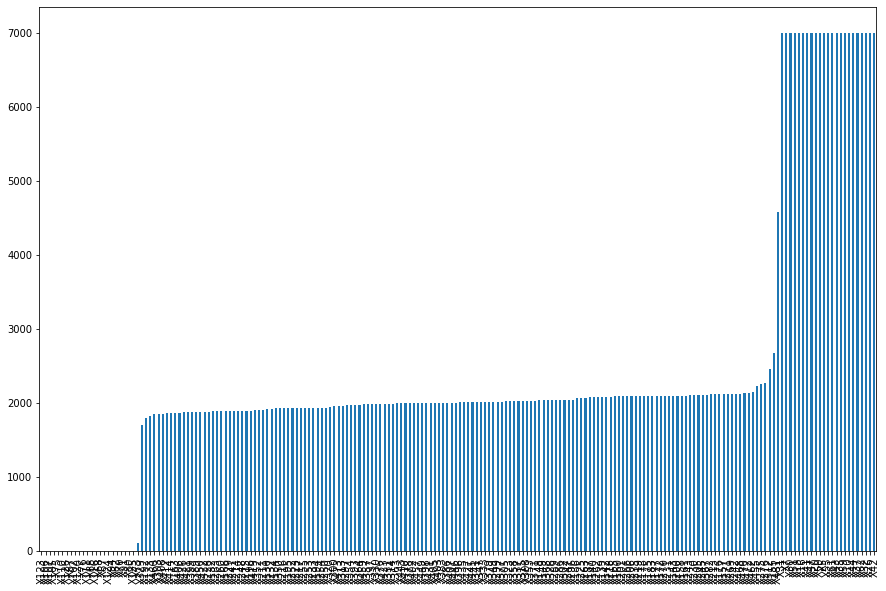

In [7]:
# 결측치 갯수 시각화
test.isnull().sum().sort_values(ascending=True).plot(kind='bar',figsize=(15,10))

* 결측치가 없는 세대를 sample로 정하여 데이터 탐색 진행

In [9]:
## 결측치가 없는 세대
test.loc[:,test.isnull().sum()==0].columns

Index(['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107'],
      dtype='object')

In [10]:
# sample 데이터
test_sample = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']]

* test_sample 데이터를 시간,일,월별로 resampleling

In [11]:
# 일
test_sample_day = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].resample(rule='D').sum()

# 월
test_sample_month = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].resample(rule='M').sum()

# 시간별
test_sample_hours = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']]

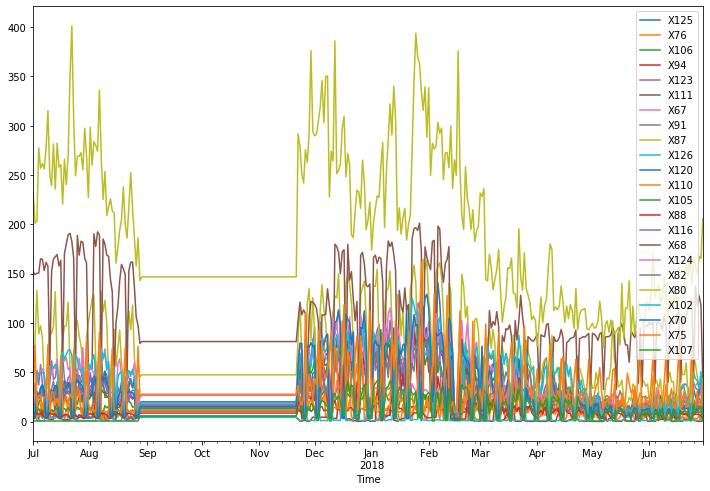

In [12]:
# 일별 전력수요량 합계

test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].resample(rule='D').sum().plot(figsize=(12,8))

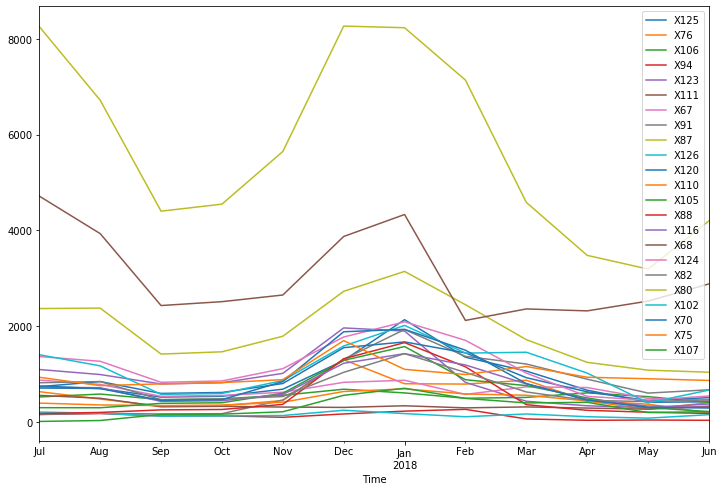

In [13]:
# 월별 전력수요량 합계

test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].resample(rule='M').sum().plot(figsize=(12,8))

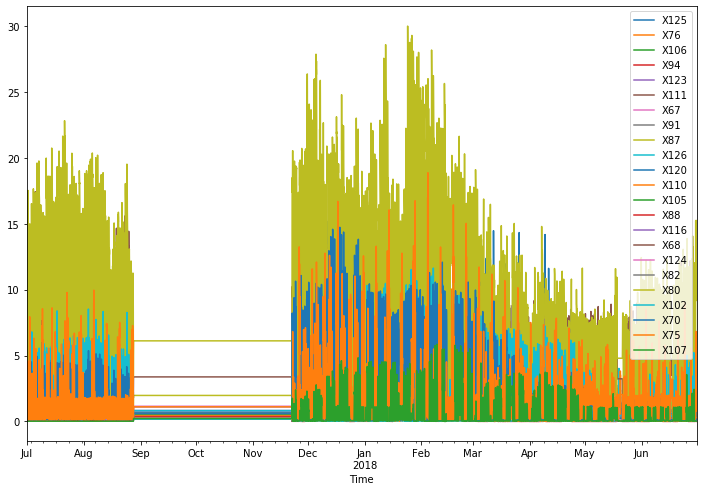

In [14]:
# 시간별 전력수요량 합계

test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].plot(figsize=(12,8))

> 결측치가 없는 test_sample에서 2017년9월~11월까지의 데이터가 같은값을 갖는 특징 확인.
    * 해당 특징이 오류인지, 특정 이유가 있는것인지 파악할 필요

> 시계열 예측을 위한 모델로 HOLT'S-WINTER, ARIMA모델을 적용해 볼것임.

> 모델 적용 전, 데이터 특성 파악 필요
    * 2017년9월~11월까지의 데이터 특징 파악
    * 주택데이터와 상가데이터의 구분
    * 계절,주말에 따른 트렌드 및 계절성 파악
    * 기온,날씨,공휴일 등 예측변수 탐색

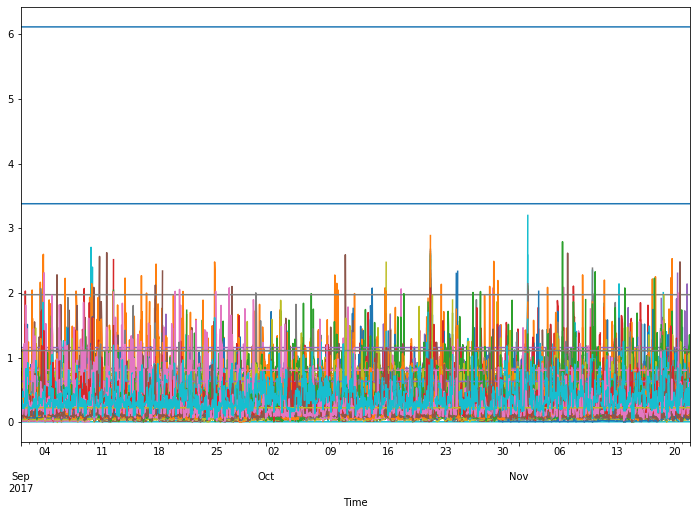

In [15]:
# test데이터 모든 데이터가 9월~11월말까지 같은 값을 갖는지 확인

test['2017-09':'2017-11-21'].plot(figsize=(12,8),legend=False)

> test셋의 모든 데이터가 17년 9월~11월말까지 같은 값을 가지는 것은 아니다.
    * 일부 데이터의 특징? vs 측정오류
    * 모델 적용시 설명력을 감소시킬 가능성 고려

* 전력수요량의 평균적인 크기로 상가와 주택을 구분해 보기

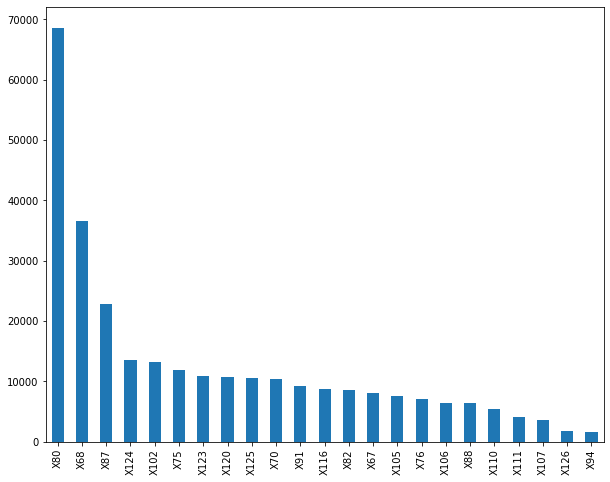

In [39]:
# 시각화 통한 판단
# 결측치 처리후 test 데이터 전체 시각화해보기
test_sample.iloc[:,].sum().sort_values(ascending=False).plot(kind='bar',figsize=(10,8))

### 3. ARIMA 

In [49]:
# X116 세대의 일별 예측을 sample로 Testing

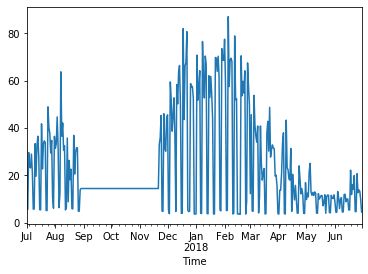

In [61]:
test_sample['X116'].resample(rule='D').sum().plot()

In [65]:
## 3.1 decompose

# decomposition 으로 확인하기

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(test_sample['X116'].resample(rule='D').sum())

<Figure size 432x288 with 0 Axes>

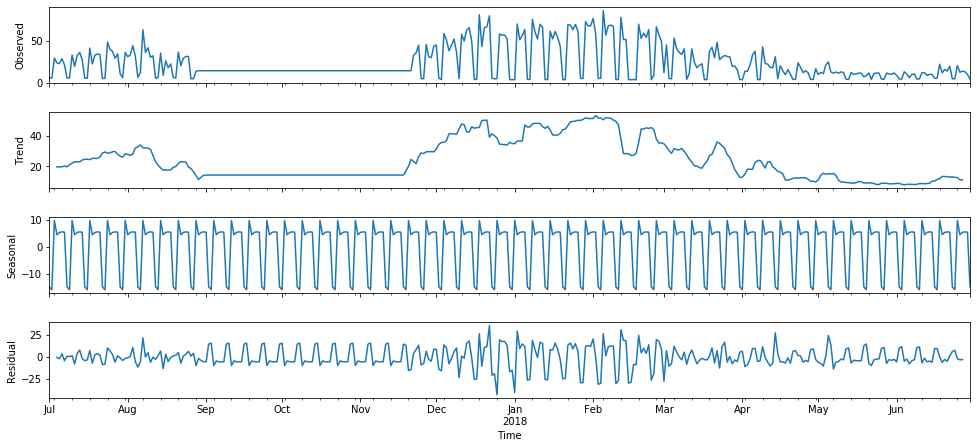

In [66]:
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,7)

In [64]:
# 3.2 stationary Test

# stationary check
def adf_check(ts):
    result = adfuller(ts)
    if result[1] <= 0.05:
        print('Stationary {}'.format(result[1]))
    else :
        print('Non-Stationary {}'.format(result[1]))

In [67]:
adf_check(test_sample['X116'].resample(rule='D').sum())

Non-Stationary 0.641699642360996


In [92]:
# 1st differencing
first_diff = (test_sample['X116'].resample(rule='D').sum() - test_sample['X116'].resample(rule='D').sum().shift(1)).dropna()
adf_check((test_sample['X116'].resample(rule='D').sum() - test_sample['X116'].resample(rule='D').sum().shift(1)).dropna())

Stationary 5.017885244993516e-10


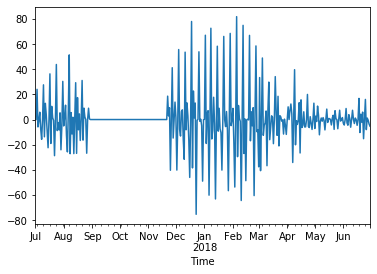

In [74]:
# 1st differencing plot
(test_sample['X116'].resample(rule='D').sum() - test_sample['X116'].resample(rule='D').sum().shift(1)).plot()

In [91]:
# seasonal differencing
seasonal_diff = (test_sample['X116'].resample(rule='D').sum() - test_sample['X116'].resample(rule='D').sum().shift(12)).dropna()
adf_check((test_sample['X116'].resample(rule='D').sum() - test_sample['X116'].resample(rule='D').sum().shift(12)).dropna())

Stationary 0.0003131105291293751


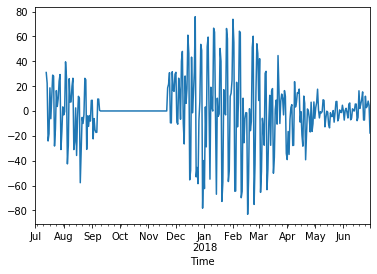

In [86]:
(test_sample['X116'].resample(rule='D').sum() - test_sample['X116'].resample(rule='D').sum().shift(12)).plot()

In [95]:
# 1st & seasonal differencing

res_diff = first_diff - seasonal_diff
adf_check(res_diff.dropna())

Stationary 0.022025364543090557


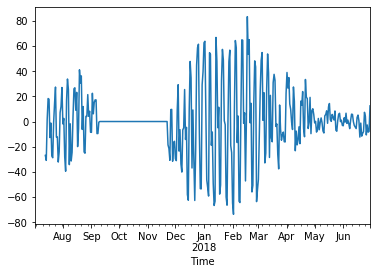

In [96]:
res_diff.plot()

In [100]:
# ARIMA

# parameter searching
import itertools
p = list(range(0,5))
d = [1]
q = [0,1]

pdq = list(itertools.product(p,d,q))

In [101]:
for param in pdq:
    model = ARIMA(test_sample['X116'], order=param)
    result = model.fit(disp=0)
    print('ARIMA{} => AIC : {}'.format(param,result.aic))

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: Value

ARIMA(0, 1, 0) => AIC : 25314.68595486614
ARIMA(0, 1, 1) => AIC : 25306.070592302593
ARIMA(1, 1, 0) => AIC : 25308.295358380547


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1) => AIC : 24532.596634943246
ARIMA(2, 1, 0) => AIC : 25210.989198067633


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1) => AIC : 24383.299870864998


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


ARIMA(3, 1, 0) => AIC : 25209.608333774475


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


ARIMA(3, 1, 1) => AIC : 24385.208331206137


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


ARIMA(4, 1, 0) => AIC : 25198.580024514355


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


ARIMA(4, 1, 1) => AIC : 24329.44602718213


In [102]:
arima_sample = test_sample['X116'].resample(rule='D').sum()

# train ,test split
X = arima_sample.values
size = int(len(X)*0.66)
train,test = X[:size],X[size:]

In [103]:
history = [x for x in train] # train은 그대로 두고 (복사본 생성)

In [104]:
predictions = []

for t in range(len(test)): # test사이즈만큼 prediction
    model = ARIMA(history, order=(4,1,1))
    result = model.fit(disp=0) # disp=0 => warnning메세지 안뜨게
    output = result.forecast() # forcast default인자는 1임 # 즉, 다음거 하나만 예측 # 배열로 저장됨
    yhat = output[0] # yhat => 예측값
    predictions.append(yhat)
    
    # 계속해서 다음꺼 예측하기 위해
    obs = test[t] 
    history.append(obs) # 하나씪 범위 늘림

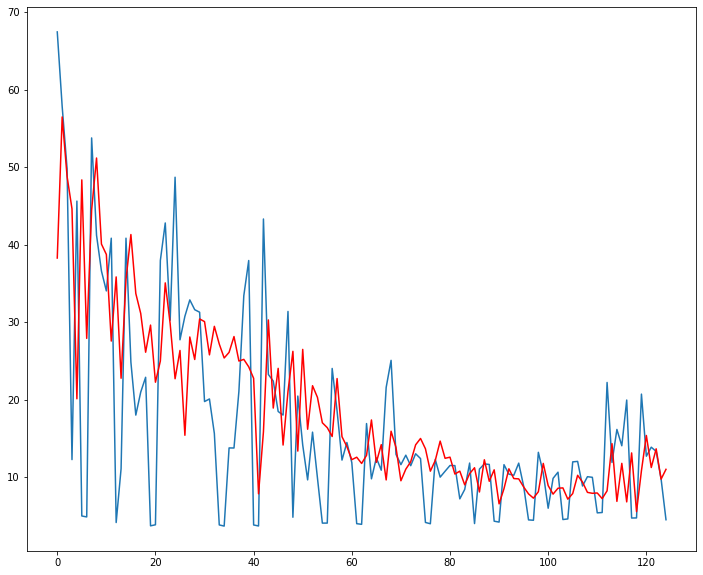

In [108]:
plt.figure(figsize=(12,10))
plt.plot(test)
plt.plot(predictions,color='red')

In [109]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test,predictions)

In [110]:
rmse = np.sqrt(error)
rmse

11.161459221054315

In [112]:
arima_sample.describe()

count    365.00000
mean      23.78091
std       20.16818
min        3.55600
25%       10.49000
50%       14.44800
75%       33.87400
max       87.00300
Name: X116, dtype: float64